In [ ]:
# ==========================================
# 0. Imports & Reproducibility
# ==========================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import json
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import umap.umap_ as umap

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ==========================================
# Paths
# ==========================================

from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "EEG_REPRESENTATION_GEOMETRY":
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.append(str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / "datasets"
RESULTS_DIR = PROJECT_ROOT / "results"
MODELS_DIR = PROJECT_ROOT / "models"
TABLES_DIR = RESULTS_DIR / "tables"
FIGURES_DIR = RESULTS_DIR / "figures"

ABLATION_TABLE_DIR = TABLES_DIR / "projection_icrr_ablation"
MODEL_COMP_FIG_DIR = FIGURES_DIR / "model_comparisons"
EMBED_FIG_DIR = FIGURES_DIR / "embedding_geometry"

for p in [ABLATION_TABLE_DIR, MODEL_COMP_FIG_DIR, EMBED_FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

DATA_PATH = DATA_DIR / "bnci_dataset" / "processed" / "preprocessed_BNCI.npz"   

Using device: cuda


In [4]:
d = np.load(DATA_PATH, allow_pickle=True)
X = d["X"].astype(np.float32)
y = d["y"].astype(int)

print("BNCI Shape:", X.shape)
print("Classes:", np.unique(y))

BNCI Shape: (640, 25, 561)
Classes: [0 1 2 3]


In [5]:
class DeepConvNet(nn.Module):

    def __init__(self, chans, samples, classes=4, dropout=0.5):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 25, (1,5), padding=(0,2), bias=False),
            nn.Conv2d(25, 25, (chans,1), bias=False),
            nn.BatchNorm2d(25),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(dropout)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(25, 50, (1,5), padding=(0,2), bias=False),
            nn.BatchNorm2d(50),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(dropout)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(50, 100, (1,5), padding=(0,2), bias=False),
            nn.BatchNorm2d(100),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(dropout)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(100, 200, (1,5), padding=(0,2), bias=False),
            nn.BatchNorm2d(200),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(dropout)
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, chans, samples)
            z = self._forward_features(dummy)
            emb_dim = z.shape[1]

        self.classifier = nn.Linear(emb_dim, classes)

    def _forward_features(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x.flatten(1)

    def forward(self, x, return_embedding=False):
        x = x.unsqueeze(1)
        z = self._forward_features(x)
        logits = self.classifier(z)
        if return_embedding:
            return logits, z
        return logits

In [6]:
def icrr_loss(embeddings, labels):

    loss = 0.0
    count = 0

    for c in labels.unique():
        idx = labels == c
        if idx.sum() < 2:
            continue

        class_emb = embeddings[idx]
        centroid = class_emb.mean(dim=0, keepdim=True)
        loss += ((class_emb - centroid) ** 2).mean()
        count += 1

    return loss / (count + 1e-8)

In [7]:
def compute_ess(embeddings, labels):

    ess = 0.0
    classes = np.unique(labels)

    for c in classes:
        idx = labels == c
        class_emb = embeddings[idx]
        centroid = class_emb.mean(axis=0)
        ess += np.mean(np.linalg.norm(class_emb - centroid, axis=1))

    return ess / len(classes)


def compute_classwise_ess(embeddings, labels):

    class_ess = {}

    for c in np.unique(labels):
        idx = labels == c
        class_emb = embeddings[idx]
        centroid = class_emb.mean(axis=0)
        class_ess[int(c)] = np.mean(
            np.linalg.norm(class_emb - centroid, axis=1)
        )

    return class_ess

In [8]:
# ==========================================
# 1. 5-Fold Training with Embedding Capture
# ==========================================

def run_kfold_icrr_with_embeddings(lambda_icrr=0.1, epochs=50):

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    all_emb_ce = []
    all_emb_icrr = []
    all_labels = []

    fold_ess_ce = []
    fold_ess_icrr = []

    ce_loss_fn = nn.CrossEntropyLoss()

    for fold, (tr, te) in enumerate(skf.split(X, y), 1):

        print(f"\n===== Fold {fold} =====")

        Xtr, Xte = X[tr], X[te]
        ytr, yte = y[tr], y[te]

        train_ds = torch.utils.data.TensorDataset(
            torch.tensor(Xtr), torch.tensor(ytr)
        )
        val_ds = torch.utils.data.TensorDataset(
            torch.tensor(Xte), torch.tensor(yte)
        )

        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False)

        # ---------------- CE ----------------
        model_ce = DeepConvNet(25, 561).to(device)
        opt_ce = optim.Adam(model_ce.parameters(), lr=1e-3)

        for ep in range(epochs):
            model_ce.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                opt_ce.zero_grad()
                logits = model_ce(xb)
                loss = ce_loss_fn(logits, yb)
                loss.backward()
                opt_ce.step()

        model_ce.eval()
        emb_ce_fold = []
        labels_fold = []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits, z = model_ce(xb, return_embedding=True)
                emb_ce_fold.append(z.cpu().numpy())
                labels_fold.append(yb.numpy())

        emb_ce_fold = np.concatenate(emb_ce_fold)
        labels_fold = np.concatenate(labels_fold)

        ess_ce = compute_ess(emb_ce_fold, labels_fold)
        fold_ess_ce.append(ess_ce)

        # ---------------- CE + ICRR ----------------
        model_icrr = DeepConvNet(25, 561).to(device)
        opt_icrr = optim.Adam(model_icrr.parameters(), lr=1e-3)

        for ep in range(epochs):
            model_icrr.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                opt_icrr.zero_grad()
                logits, z = model_icrr(xb, return_embedding=True)
                loss = ce_loss_fn(logits, yb) + lambda_icrr * icrr_loss(z, yb)
                loss.backward()
                opt_icrr.step()

        model_icrr.eval()
        emb_icrr_fold = []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits, z = model_icrr(xb, return_embedding=True)
                emb_icrr_fold.append(z.cpu().numpy())

        emb_icrr_fold = np.concatenate(emb_icrr_fold)

        ess_icrr = compute_ess(emb_icrr_fold, labels_fold)
        fold_ess_icrr.append(ess_icrr)

        # Save fold embeddings
        all_emb_ce.append(emb_ce_fold)
        all_emb_icrr.append(emb_icrr_fold)
        all_labels.append(labels_fold)

    # Concatenate across folds
    global_emb_ce = np.concatenate(all_emb_ce)
    global_emb_icrr = np.concatenate(all_emb_icrr)
    global_labels = np.concatenate(all_labels)

    return (
        global_emb_ce,
        global_emb_icrr,
        global_labels,
        fold_ess_ce,
        fold_ess_icrr
    )

In [9]:
(
    emb_ce_global,
    emb_icrr_global,
    labels_global,
    fold_ess_ce,
    fold_ess_icrr
) = run_kfold_icrr_with_embeddings(lambda_icrr=0.1, epochs=50)

print("Global embedding shape:", emb_ce_global.shape)


===== Fold 1 =====

===== Fold 2 =====

===== Fold 3 =====

===== Fold 4 =====

===== Fold 5 =====
Global embedding shape: (640, 7000)


In [ ]:
global_ess_ce = compute_ess(emb_ce_global, labels_global)
global_ess_icrr = compute_ess(emb_icrr_global, labels_global)

results_dict = {
    "ESS_CE_mean_fold": float(np.mean(fold_ess_ce)),
    "ESS_ICRR_mean_fold": float(np.mean(fold_ess_icrr)),
    "ESS_CE_global": float(global_ess_ce),
    "ESS_ICRR_global": float(global_ess_icrr)
}

with open(ABLATION_TABLE_DIR / "compactness_summary.json", "w") as f:
    json.dump(results_dict, f, indent=4)

print(results_dict)

{'ESS_CE_mean_fold': 41.66569900512695, 'ESS_ICRR_mean_fold': 31.889820098876953, 'ESS_CE_global': 44.00046920776367, 'ESS_ICRR_global': 33.852081298828125}


In [11]:
# ==========================================
# Global UMAP Projection
# ==========================================

combined_embeddings = np.concatenate([emb_ce_global, emb_icrr_global])

reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.01,
    metric="euclidean",
    random_state=42
)

reducer.fit(combined_embeddings)

umap_ce = reducer.transform(emb_ce_global)
umap_icrr = reducer.transform(emb_icrr_global)

c:\Users\roger\Desktop\vs_code\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


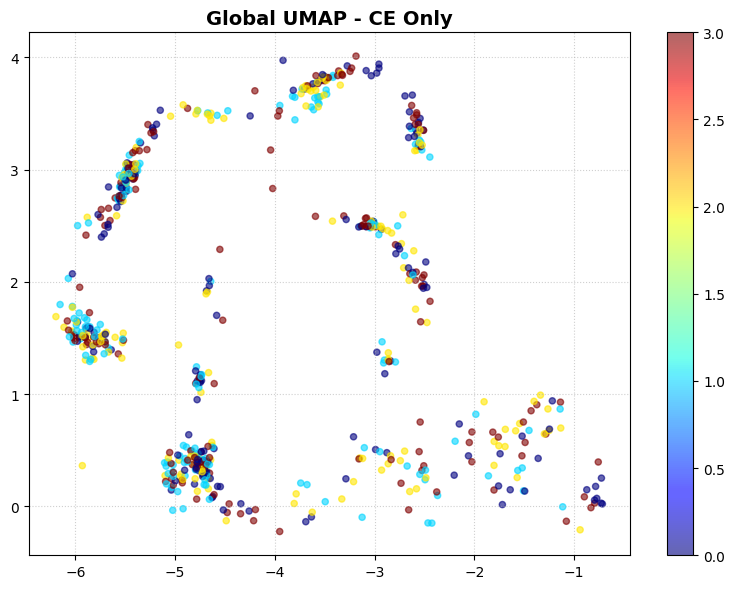

In [ ]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    umap_ce[:,0],
    umap_ce[:,1],
    c=labels_global,
    cmap="jet",
    s=20,
    alpha=0.6
)

plt.title("Global UMAP - CE Only", fontsize=14, fontweight="bold")
plt.colorbar(scatter)
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()

plt.savefig(MODEL_COMP_FIG_DIR / "umap_backbone_ce.png", dpi=300, bbox_inches="tight")
plt.show()

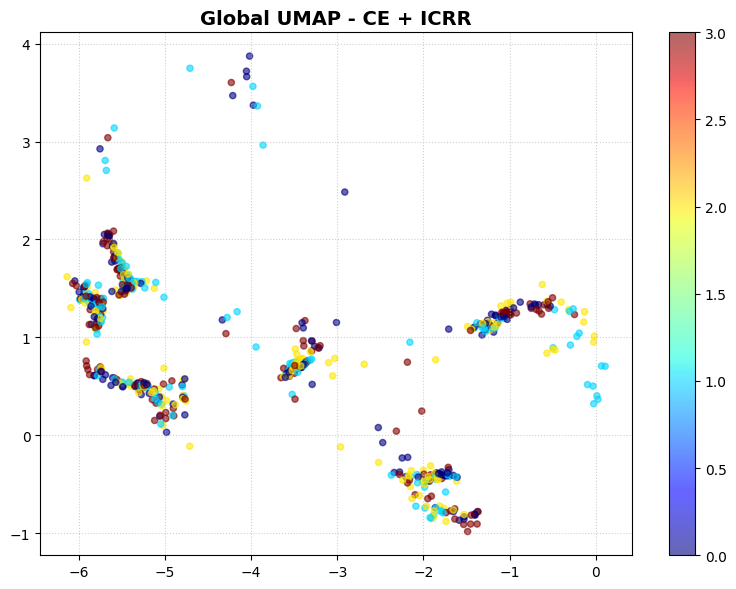

In [ ]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    umap_icrr[:,0],
    umap_icrr[:,1],
    c=labels_global,
    cmap="jet",
    s=20,
    alpha=0.6
)

plt.title("Global UMAP - CE + ICRR", fontsize=14, fontweight="bold")
plt.colorbar(scatter)
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()

plt.savefig(MODEL_COMP_FIG_DIR / "umap_backbone_icrr.png", dpi=300, bbox_inches="tight")
plt.show()

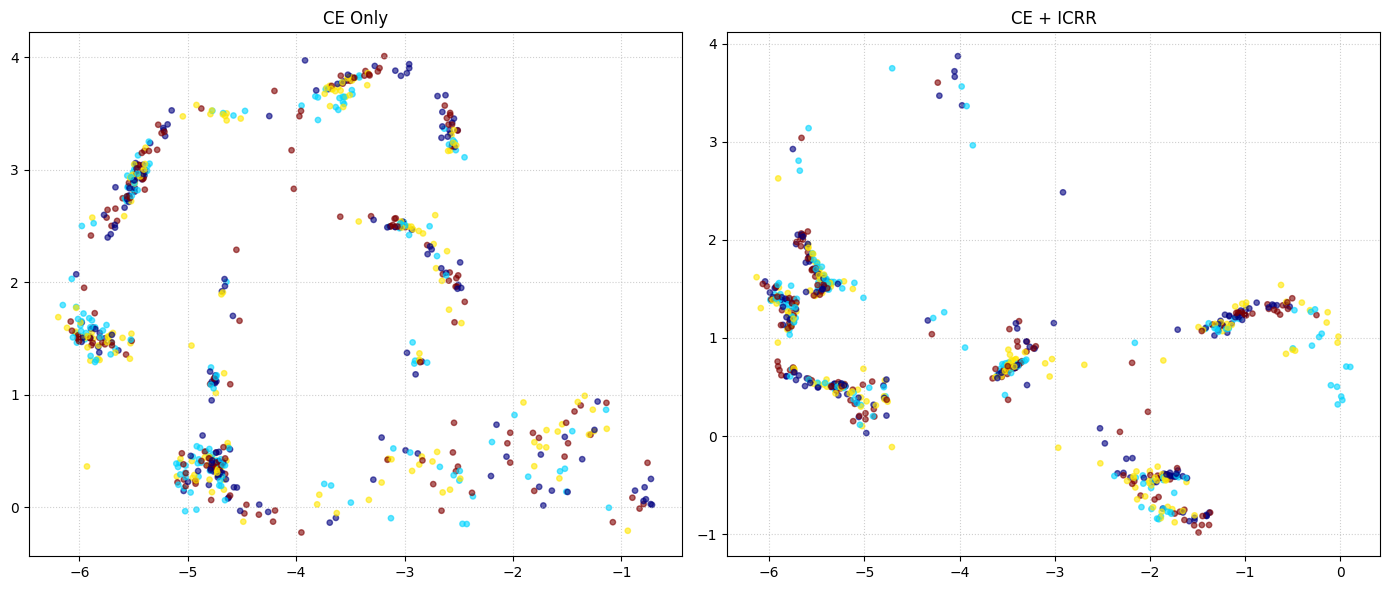

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(14,6))

axes[0].scatter(
    umap_ce[:,0], umap_ce[:,1],
    c=labels_global,
    cmap="jet", s=15, alpha=0.6
)
axes[0].set_title("CE Only")

axes[1].scatter(
    umap_icrr[:,0], umap_icrr[:,1],
    c=labels_global,
    cmap="jet", s=15, alpha=0.6
)
axes[1].set_title("CE + ICRR")

for ax in axes:
    ax.grid(True, linestyle=":", alpha=0.6)

plt.tight_layout()
plt.savefig(MODEL_COMP_FIG_DIR / "umap_backbone_ce_vs_icrr.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# ==========================================
# Embedding Geometry Diagnostics (CE vs ICRR)
# Saves to: results/figures/embedding_geometry/
# ==========================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# --------------------------------------------------
# 1️⃣ Pairwise Cosine Similarity Heatmap (Sorted)
# --------------------------------------------------
sort_idx = np.argsort(labels_global)
labels_sorted = labels_global[sort_idx]
emb_ce_sorted = emb_ce_global[sort_idx]
emb_icrr_sorted = emb_icrr_global[sort_idx]

sim_ce = cosine_similarity(emb_ce_sorted)
sim_icrr = cosine_similarity(emb_icrr_sorted)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(sim_ce, cmap='viridis', ax=axes[0], cbar=True,
            xticklabels=False, yticklabels=False)
axes[0].set_title("CE Only - Pairwise Similarity", fontsize=13, fontweight="bold")

sns.heatmap(sim_icrr, cmap='viridis', ax=axes[1], cbar=True,
            xticklabels=False, yticklabels=False)
axes[1].set_title("CE + ICRR - Pairwise Similarity", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.savefig(EMBED_FIG_DIR / "pairwise_similarity_heatmap.png",
            dpi=300, bbox_inches="tight")
plt.show()


# --------------------------------------------------
# 2️⃣ Distance Distribution (Intra vs Inter)
# --------------------------------------------------
def get_distances(embeddings, labels):
    intra_dists = []
    inter_dists = []
    classes = np.unique(labels)
    centroids = {c: embeddings[labels == c].mean(axis=0) for c in classes}

    for i, emb in enumerate(embeddings):
        true_c = labels[i]
        intra_dists.append(np.linalg.norm(emb - centroids[true_c]))
        other_dists = [
            np.linalg.norm(emb - centroids[c])
            for c in classes if c != true_c
        ]
        inter_dists.append(np.min(other_dists))

    return np.array(intra_dists), np.array(inter_dists)

intra_ce, inter_ce = get_distances(emb_ce_global, labels_global)
intra_icrr, inter_icrr = get_distances(emb_icrr_global, labels_global)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.kdeplot(intra_ce, fill=True, ax=axes[0], label="Intra-class")
sns.kdeplot(inter_ce, fill=True, ax=axes[0], label="Nearest inter-class")
axes[0].set_title("CE Only - Distance Distribution", fontsize=13, fontweight="bold")
axes[0].legend()

sns.kdeplot(intra_icrr, fill=True, ax=axes[1], label="Intra-class")
sns.kdeplot(inter_icrr, fill=True, ax=axes[1], label="Nearest inter-class")
axes[1].set_title("CE + ICRR - Distance Distribution", fontsize=13, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.savefig(EMBED_FIG_DIR / "distance_distribution_kde.png",
            dpi=300, bbox_inches="tight")
plt.show()


# --------------------------------------------------
# 3️⃣ PCA Projection
# --------------------------------------------------
pca = PCA(n_components=2)

pca_ce = pca.fit_transform(emb_ce_global)
pca_icrr = pca.fit_transform(emb_icrr_global)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(pca_ce[:, 0], pca_ce[:, 1],
                c=labels_global, cmap='jet', s=20, alpha=0.7)
axes[0].set_title("CE Only - PCA", fontsize=13, fontweight="bold")
axes[0].grid(True, linestyle=":", alpha=0.6)

axes[1].scatter(pca_icrr[:, 0], pca_icrr[:, 1],
                c=labels_global, cmap='jet', s=20, alpha=0.7)
axes[1].set_title("CE + ICRR - PCA", fontsize=13, fontweight="bold")
axes[1].grid(True, linestyle=":", alpha=0.6)

plt.tight_layout()
plt.savefig(EMBED_FIG_DIR / "pca_embedding_projection.png",
            dpi=300, bbox_inches="tight")
plt.show()


# --------------------------------------------------
# 4️⃣ 3D UMAP
# --------------------------------------------------
reducer_3d = umap.UMAP(n_components=3, random_state=42)

umap3d_ce = reducer_3d.fit_transform(emb_ce_global)
umap3d_icrr = reducer_3d.fit_transform(emb_icrr_global)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(umap3d_ce[:, 0], umap3d_ce[:, 1], umap3d_ce[:, 2],
            c=labels_global, cmap='jet', s=15, alpha=0.7)
ax1.set_title("CE Only - 3D UMAP", fontsize=13, fontweight="bold")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(umap3d_icrr[:, 0], umap3d_icrr[:, 1], umap3d_icrr[:, 2],
            c=labels_global, cmap='jet', s=15, alpha=0.7)
ax2.set_title("CE + ICRR - 3D UMAP", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.savefig(EMBED_FIG_DIR / "umap_3d_backbone_ce_vs_icrr.png",
            dpi=300, bbox_inches="tight")
plt.show()


# --------------------------------------------------
# 5️⃣ ESS Delta Waterfall
# --------------------------------------------------
def get_intra_distances(embeddings, labels):
    classes = np.unique(labels)
    centroids = {c: embeddings[labels == c].mean(axis=0) for c in classes}
    return np.array([
        np.linalg.norm(embeddings[i] - centroids[labels[i]])
        for i in range(len(labels))
    ])

dist_ce = get_intra_distances(emb_ce_global, labels_global)
dist_icrr = get_intra_distances(emb_icrr_global, labels_global)

improvement = np.sort(dist_ce - dist_icrr)[::-1]

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['green' if x > 0 else 'red' for x in improvement]

ax.bar(range(len(improvement)), improvement,
       color=colors, width=1.0)
ax.axhline(0, color='black', linewidth=1)

ax.set_title("Per-Sample Distance Improvement (CE vs ICRR)",
             fontsize=13, fontweight="bold")
ax.set_ylabel("Distance Reduction")
ax.set_xlabel("Samples (Sorted)")
ax.grid(True, axis='y', linestyle=":", alpha=0.6)

plt.tight_layout()
plt.savefig(EMBED_FIG_DIR / "ess_delta_waterfall.png",
            dpi=300, bbox_inches="tight")
plt.show()